# NLP 2 : Neural Embeddings, Text Classification, Text Generation


To use statistical classifiers with text, it is first necessary to vectorize the text. In the first practical session we explored the **bag of word** model. 

Modern **state of the art** methods uses  embeddings to vectorize the text before classification in order to avoid feature engineering.

## Dataset
https://github.com/cedias/practicalNLP/tree/master/dataset

## "Modern" NLP pipeline

By opposition to the **bag of word** model, in the modern NLP pipeline everything is **embeddings**. Instead of encoding a text as a **sparse vector** of length $D$ (size of feature dictionnary) the goal is to encode the text in a meaningful dense vector of a small size $|e| <<< |D|$. 


The raw classification pipeline is then the following:

```
raw text ---|embedding table|-->  vectors --|Neural Net|--> class 
```


### Using a  language model:

How to tokenize the text and extract a feature dictionnary is still a manual task. To directly have meaningful embeddings, it is common to use a pre-trained language model such as `word2vec` which we explore in this practical.

In this setting, the pipeline becomes the following:
```
      
raw text ---|(pre-trained) Language Model|--> vectors --|classifier (or fine-tuning)|--> class 
```


- #### Classic word embeddings

 - [Word2Vec](https://arxiv.org/abs/1301.3781)
 - [Glove](https://nlp.stanford.edu/projects/glove/)


- #### bleeding edge language models techniques (only here for reference)

 - [UMLFIT](https://arxiv.org/abs/1801.06146)
 - [ELMO](https://arxiv.org/abs/1802.05365)
 - [GPT](https://blog.openai.com/language-unsupervised/)
 - [BERT](https://arxiv.org/abs/1810.04805)






### Goal of this session:

1. Train word embeddings on training dataset
2. Tinker with the learnt embeddings and see learnt relations
3. Tinker with pre-trained embeddings.
4. Use those embeddings for classification
5. Compare different embedding models
6. Pytorch first look: learn to generate text.





##  Loading data (same as in nlp 1)

In [1]:
import json
from collections import Counter

#### /!\ YOU NEED TO UNZIP dataset/json_pol.zip first /!\


# Loading json
with open("data/json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")



Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

## Word2Vec: Quick Recap

**[Word2Vec](https://arxiv.org/abs/1301.3781) is composed of two distinct language models (CBOW and SG), optimized to quickly learn word vectors**


given a random text: `i'm taking the dog out for a walk`



### (a) Continuous Bag of Word (CBOW)
    -  predicts a word given a context
    
maximizing `p(dog | i'm taking the ___ out for a walk)`
    
### (b) Skip-Gram (SG)               
    -  predicts a context given a word
    
 maximizing `p(i'm taking the out for a walk | dog)`



   

## Step 1: train (or load) a language model (word2vec)

Gensim has one of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) fastest implementation.


### Train:

In [2]:
import gensim
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

text = [t.split() for t,p in train]

# the following configuration is the default configuration
w2v = gensim.models.word2vec.Word2Vec(sentences=text,
                                vector_size=100, window=5,     ### here we train a cbow model 
                                min_count=5,                      
                                sample=0.001, workers=3,
                                sg=1, hs=0, negative=5,        ### set sg to 1 to train a sg model
                                cbow_mean=1,
                                epochs=5)

2022-02-04 17:40:01,545 : INFO : collecting all words and their counts
2022-02-04 17:40:01,547 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-04 17:40:03,382 : INFO : PROGRESS: at sentence #10000, processed 2358544 words, keeping 155393 word types
2022-02-04 17:40:05,212 : INFO : PROGRESS: at sentence #20000, processed 4675912 words, keeping 243050 word types
2022-02-04 17:40:06,148 : INFO : collected 280617 word types from a corpus of 5844680 raw words and 25000 sentences
2022-02-04 17:40:06,150 : INFO : Creating a fresh vocabulary
2022-02-04 17:40:07,271 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 49345 unique words (17.584465659600095%% of original 280617, drops 231272)', 'datetime': '2022-02-04T17:40:07.270482', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'prepare_vocab'}
2022-02-04 17:40:07,272 : INFO : Word2Vec 

### Load pre-trained embeddings:

In [3]:
# It's for later
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
# w2v = KeyedVectors.load_word2vec_format(datapath('downloaded_vectors_path'), binary=False)
word_vectors = w2v.wv
word_vectors.save("downloaded_vectors_path")
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("downloaded_vectors_path", mmap='r')

vector = wv['car']  # Get numpy vector of a word

2022-02-04 17:43:27,500 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-04 17:43:27,502 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
2022-02-04 17:43:27,503 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)", 'datetime': '2022-02-04T17:43:27.503369', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19042-SP0', 'event': 'created'}
2022-02-04 17:43:27,859 : INFO : KeyedVectors lifecycle event {'fname_or_handle': 'downloaded_vectors_path', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-04T17:43:27.859537', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'plat

In Gensim, embeddings are loaded and can be used via the ["KeyedVectors"](https://radimrehurek.com/gensim/models/keyedvectors.html) class

> Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure, as implemented in this module.

>The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}.

>The entity typically corresponds to a word (so the mapping maps words to 1D vectors), but for some models, they key can also correspond to a document, a graph node etc. To generalize over different use-cases, this module calls the keys entities. Each entity is always represented by its string id, no matter whether the entity is a word, a document or a graph node.

## STEP 2: Test learnt embeddings

The word embedding space directly encodes similarities between words: the vector coding for the word "great" will be closer to the vector coding for "good" than to the one coding for "bad". Generally, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is the distance used when considering distance between vectors.

KeyedVectors have a built in [similarity](https://radimrehurek.com/gensim/models /keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.similarity) method to compute the cosine similarity between words

In [4]:
# is great really closer to good than to bad ?
print("great and good:",w2v.wv.similarity("great","good"))
print("great and bad:",w2v.wv.similarity("great","bad"))

great and good: 0.77765757
great and bad: 0.49547234


Since cosine distance encodes similarity, neighboring words are supposed to be similar. The [most_similar](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.BaseKeyedVectors.most_similar) method returns the `topn` words given a query.

In [5]:
# The query can be as simple as a word, such as "movie"
# Try changing the word
print(w2v.wv.most_similar("movie",topn=5),"\n") # 5 most similar words
print(w2v.wv.most_similar("awesome",topn=5),"\n")
print(w2v.wv.most_similar("actor",topn=5),"\n")

[('film', 0.9414064288139343), ('"film"', 0.84061199426651), ('"movie"', 0.7907540202140808), ('movie...', 0.7837522625923157), ('movie,', 0.7767480611801147)] 

[('amazing', 0.7784026265144348), ('excellent', 0.7351272106170654), ('incredible', 0.7315266132354736), ('awesome,', 0.7096130847930908), ('fantastic', 0.694219172000885)] 

[('actor,', 0.8408632874488831), ('actor.', 0.7756488919258118), ('comedian', 0.7745350003242493), ('actress', 0.7510592341423035), ('actor)', 0.7501669526100159)] 



But it can be a more complicated query
Word embedding spaces tend to encode much more.

The most famous exemple is: `vec(king) - vec(man) + vec(woman) => vec(queen)`

In [6]:
# What is awesome - good + bad ?
print(w2v.wv.most_similar(positive=["awesome","bad"],negative=["good"],topn=3),"\n")  
print(w2v.wv.most_similar(positive=["actor","woman"],negative=["man"],topn=3),"\n") # do the famous exemple works for actor ?


# Try other things like plurals for exemple.
print(w2v.wv.most_similar(positive=["men","man"],negative=["women"],topn=3),"\n")

[('awful', 0.7432842254638672), ('unbelievably', 0.6427719593048096), ('unbelievable', 0.6403261423110962)] 

[('actress', 0.8484925031661987), ('actress,', 0.759199857711792), ('actress.', 0.7074642777442932)] 

[('man,', 0.7141423225402832), ('soldier', 0.7004864811897278), ('devil', 0.6913885474205017)] 



To test learnt "synctactic" and "semantic" similarities, Mikolov et al. introduced a special dataset containing a wide variety of three way similarities.

In [7]:
out = w2v.wv.evaluate_word_analogies("data/questions-words.txt",case_insensitive=True)  # original semantic syntactic dataset.

2022-02-04 17:43:28,307 : INFO : Evaluating word analogies for top 300000 words in the model on data/questions-words.txt
2022-02-04 17:43:28,784 : INFO : capital-common-countries: 1.3% (2/156)
2022-02-04 17:43:29,155 : INFO : capital-world: 1.8% (2/111)
2022-02-04 17:43:29,222 : INFO : currency: 0.0% (0/18)
2022-02-04 17:43:30,166 : INFO : city-in-state: 0.0% (0/301)
2022-02-04 17:43:31,345 : INFO : family: 31.0% (130/420)
2022-02-04 17:43:34,066 : INFO : gram1-adjective-to-adverb: 1.7% (15/870)
2022-02-04 17:43:35,829 : INFO : gram2-opposite: 2.9% (16/552)
2022-02-04 17:43:39,609 : INFO : gram3-comparative: 21.1% (251/1190)
2022-02-04 17:43:41,998 : INFO : gram4-superlative: 10.1% (76/756)
2022-02-04 17:43:44,528 : INFO : gram5-present-participle: 18.1% (147/812)
2022-02-04 17:43:47,134 : INFO : gram6-nationality-adjective: 1.4% (14/967)
2022-02-04 17:43:50,691 : INFO : gram7-past-tense: 19.4% (244/1260)
2022-02-04 17:43:53,020 : INFO : gram8-plural: 8.4% (68/812)
2022-02-04 17:43:54,

When training the w2v models on the review dataset, since it hasn't been learnt with a lot of data, it does not perform very well. 


## STEP 3:  sentiment classification

In the previous practical session, we used a bag of word approach to transform text into vectors.
Here, we propose to try to use word vectors (previously learnt or loaded).


### <font color='green'> Since we have only word vectors and that sentences are made of multiple words, we need to aggregate them. </font>


### (1) Vectorize reviews using word vectors:

Word aggregation can be done in different ways:

- Sum
- Average
- Min/feature
- Max/feature

#### a few pointers:

- `w2v.wv.vocab` is a `set()` of the vocabulary (all existing words in your model)
- `np.minimum(a,b) and np.maximum(a,b)` respectively return element-wise min/max 

In [8]:
import numpy as np
# We first need to vectorize text:
# First we propose to a sum of them

def vectorize(text,types="max"):
    """
    This function should vectorize one review

    input: str
    output: np.array(float)
    """   
    vec = []
    for i in text.split():
        try :
            vec.append(wv[i])
        except :
            vec.append(np.zeros(100))
    if types == "mean" :
        return np.array(vec).mean(axis=1)
    if types == "sum":    
        return np.array(vec).sum(axis=1)
    if types == "max" :
        return np.array(vec).max(axis=1)
    if types == "min" :
        return np.array(vec).min(axis=1)

classes = np.array([pol for text,pol in train])
X = np.array([vectorize(text) for text,pol in train])
X_test = np.array([vectorize(text) for text,pol in test])
true = np.array([pol for text,pol in test])

#let's see what a review vector looks like.
print(X[0])

C:\Users\karna\AppData\Local\Temp/ipykernel_43744/2987936085.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([vectorize(text) for text,pol in train])


[0.7205323  0.33217111 0.76288635 0.71961647 0.81379908 0.7711339
 0.58910245 0.8836444  0.31675652 0.97963476 0.87693894 0.59793925
 0.72714204 0.63566655 0.6597085  0.78417248 0.78417248 0.48525462
 0.74175191 0.7844258  0.61915094 0.98100191 0.76592702 1.12544572
 0.         0.72236139 0.94140059 1.00824738 0.7440486  0.99137551
 0.56536472 0.63652253 0.78923917 0.80187738 0.72668231 0.
 0.8410598  0.95025527 1.04193282 0.58910245 0.80914617 0.62772691
 0.63727248 0.6597085  0.6016956  0.65359098 0.6597085  0.63810831
 0.72436208 0.71709609 0.83464044 0.56803608 0.70039725 0.52489817
 0.41782096 0.59577477 0.98100191 0.58910245 0.5878877  0.5381825
 0.94468892 0.6597085  0.82569003 0.73023117 0.95035326 1.00194156
 0.66618431 0.76376259 0.72236139 0.77242357 0.52489817 0.74918562
 0.73737693 0.44011602 0.96004492 0.8836444  0.31675652 0.4367055
 0.90998125 0.6597085  0.79030973 0.76603657 0.72236139 0.69335282
 0.75130635 0.94621289 0.98100191 0.84246939 0.81566602 0.7395559
 0.6731

C:\Users\karna\AppData\Local\Temp/ipykernel_43744/2987936085.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array([vectorize(text) for text,pol in test])


In [9]:
print(len(X[2]))

179


### (2) Train a classifier 
as in the previous practical session, train a logistic regression to do sentiment classification with word vectors



In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import svm

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
# print(X_train.shape)
# print(X_test.shape)
# print(Y_train.shape)
# print(Y_test.shape)

maxi = 0
for i in range(X.shape[0]):
    if len(X[i]) > maxi:
        maxi = len(X[i])
print(maxi)

padded_array = np.zeros((X.shape[0], maxi))
n,m = padded_array.shape
print(n, m)
for i in range(n):
    for j in range(m):
        if j < len(X[i]):
            padded_array[i][j] = X[i][j]
print(padded_array.shape)

2470
25000 2470
(25000, 2470)


In [11]:
padded_array_test = np.zeros((X_test.shape[0], maxi))
n,m = padded_array_test.shape
print(n, m)
for i in range(n):
    for j in range(m):
        if j < len(X_test[i]):
            padded_array_test[i][j] = X_test[i][j]
print(padded_array_test.shape)

25000 2470
(25000, 2470)


In [12]:
clf = svm.SVC(max_iter=1000)
clf.fit(padded_array, classes)

C:\Users\karna\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=1000)

In [13]:
preds = clf.predict(padded_array_test)
print(accuracy_score(preds, true))
print(classification_report(preds, true))
print(f1_score(preds, true))

0.4994
              precision    recall  f1-score   support

           0       0.16      0.50      0.25      4135
           1       0.83      0.50      0.62     20865

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.44     25000
weighted avg       0.72      0.50      0.56     25000

0.6249063389779709


performance should be worst than with bag of word (~80%). Sum/Mean aggregation does not work well on long reviews (especially with many frequent words). This adds a lot of noise.

## **Todo** :  Try answering the following questions:

- Which word2vec model works best: skip-gram or cbow
- Do pretrained vectors work best than those learnt on the train dataset ?



**(Bonus)** To have a better accuracy, we could try two things:
- Better aggregation methods (weight by tf-idf ?)
- Another word vectorizing method such as [fasttext](https://radimrehurek.com/gensim/models/fasttext.html)
- A document vectorizing method such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [16]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data/input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [17]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[94, 21, 10, 13, 34, 94, 10, 23, 13, 94],
        [18, 21, 14, 28, 94, 28, 22, 24, 29, 14],
        [18, 23, 16, 82, 94, 24, 68, 94, 42, 24],
        [94, 10, 27, 14, 94, 29, 17, 24, 30, 94]]), tensor([[21, 10, 13, 34, 94, 10, 23, 13, 94, 22],
        [21, 14, 28, 94, 28, 22, 24, 29, 14, 82],
        [23, 16, 82, 94, 24, 68, 94, 42, 24, 13],
        [10, 27, 14, 94, 29, 17, 24, 30, 94, 17]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [22]:
import torch.nn.functional as f

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(n_char, hidden_size)
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = rnn_cell(hidden_size, hidden_size)
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden

## Text generation function

Sample text from the model

In [23]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted

## Training loop for net

In [30]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 10000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
lr = 0.005
batch_size = 16
chunk_len = 20

####

model = RNN(n_characters, hidden_size, n_characters, n_layers, nn.LSTM) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss = criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 3s (100 1%) 2.6477]
Whond finclou'ind whe,
CYe lougousand:'dou ou ge ee ave the RSofe

The he I'sold ome:
Hindest tonds cl 

 6s (200 2%) 2.6083]
Whours o the t om tsp theverin t?
Bold foul t nds G HO:
CES:
Ance thingonghayoty che hit d f ke fe ne  

 10s (300 3%) 2.5370]
Whe

Wh fo s t ngh; t totoute.
Fouserghes ch hend e
PELOROnd!
But nget bess lfofithinghithid oror hesh 

 13s (400 4%) 2.4856]
Wheut I ed lighallloulltho he s thiate the, omencheyous beres wneours e t bly ll n shell f on seanthet 

 17s (500 5%) 2.5186]
Whyon pend o co'sthe supof thano f, al t me 's blespe me k t sif anomt, wit asut l than crtothod f aif 

 20s (600 6%) 2.4362]
Whe bithtare rswilern wac meyon y wswns bererdo hatory, t lellour bomas ma yoruce We? athare thesht wa 

 24s (700 7%) 2.6074]
Whean ma tr se

Be vin athighe
S:


I nd l y thelyof s yoothe t s be whrd gen by la uper t wo m s s ti 

 28s (800 8%) 2.5466]
Whait, ind d,
ped I t ched bloutor athatct wighe onnd I siovere,

Wamo nder froved the, ON 

## Visualize loss 

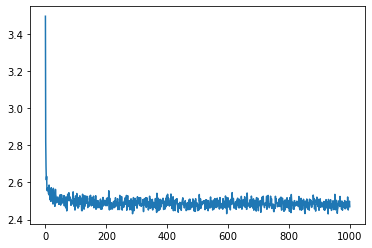

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.show()

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [32]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")
print(generate(model,'Th', 200, temperature=0.5))
print("----")
print(generate(model,'Th', 200, temperature=0.3))
print("----")
print(generate(model,'Th', 200, temperature=0.1))

Tho'st:
Ceds thaisthath withel e ad-wo'sowour ous; weryooret t.
OMonge doul te ncthild the, thinds KEMalo h ake, sear MIS:
Meayrdanen ondshe, f,
Bsiow!

RI poncercilfougor ad y ath by l talftheram tome
----
Thire t arlffun towa an o fl athatt ghey sthin pas withe? tofower touliliose be thathe ar,
We othes brougher ilde f po nd's,
WAsthes wil he mamanery y lldutha ola d s
Anor f hy was.
Yourgoy spe igen pim
----
The the I ind athand the athe Ise t ss t ar the s ter y the whe t therire ther parthe s s thathe knd the n we ce whe ave he the dis the I ay t the he wor cer t thee t t ar the bous wnd ar s be wime was 
----
The the the than t and t y the the the w, the be the an the the t the there t wind the s the ard tourd the the f the be thand we ar thanour s the t the the t t be the the wand the the the the tho we the
----
The the the the the the the the the t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the and

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


## ------ End of practical

#### Legacy loading code

In [33]:
# import glob
# from os.path import split as pathsplit

# dir_train = "data/aclImdb/train/"
# dir_test = "data/aclImdb/test/"

# train_files = glob.glob(dir_train+'pos/*.txt') + glob.glob(dir_train+'neg/*.txt')
# test_files = glob.glob(dir_test+'pos/*.txt') + glob.glob(dir_test+'neg/*.txt')


# def get_polarity(f):
#     """
#     Extracts polarity from filename:
#     0 is negative (< 5)
#     1 is positive (> 5)
#     """
#     _,name = pathsplit(f)
#     if int(name.split('_')[1].split('.')[0]) < 5:
#         return 0
#     else:
#         return 1


# def open_one(f):
    
#     polarity = get_polarity(f)
    
#     with open(f,"r") as review:
#         text = " ".join(review.readlines()).strip()
    
#     return (text,polarity)

# print(open_one(train_files[0]))

# train = [open_one(x) for x in train_files] #contains (text,pol) couples
# test = [open_one(x) for x in test_files]   #contains (text,pol) couples